### First, we download the data from the NIH Gene Expression Omnibus and write it to disk.

In [1]:
import requests

print('Downloading compressed data')

url = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92332/suppl/GSE92332%5FSalmHelm%5FUMIcounts%2Etxt%2Egz'
r = requests.get(url)
compressed_file_name = './GSE92332_SalmHelm_UMIcounts.txt.gz'

with open(compressed_file_name, 'wb') as f:
    f.write(r.content)
    
print("Data successfully written to disk")

Data successfully written to disk


### Next, we read in the file and begin preprocessing

In [2]:
import gzip
import pandas as pd

with gzip.open(compressed_file_name, 'rb') as f:
    df = pd.read_csv(f, sep='\t')

The data was originally stored with each gene being a row and each cell being a column. We'll transpose our data matrix to have a more standard arrangement of rows being samples and features being columns

In [3]:
df = df.transpose()

Next, we'll extract metadata from each cell's name. First, we'll display a sample of cell names.

In [4]:
df.head()

,A130010J15Rik,A130014A01Rik,A130051J06Rik,A130057D12Rik,A1cf,A230005M16Rik,A230046K03Rik,A230050P20Rik,A230060F14Rik,A230065N10Rik,...,Zufsp,Zw10,Zwilch,Zwint,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B1_AAACGCACGAGGAC_Control_Stem,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B1_AAACGCACTAGCCA_Control_Stem,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
B1_AAACGCACTGTCCC_Control_Stem,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that these names contain a number of useful pieces of metadata (e.g. cell type) separated by the `_` character. We'll extract that metadata here.

In [6]:
cell_groups = []
barcodes = []
conditions = []
cell_types = []

for cell in df.index:
    cell_group, barcode, condition, cell_type = cell.split('_')
    cell_groups.append(cell_group)
    barcodes.append(barcode)
    conditions.append(condition)
    cell_types.append(cell_type)
    
metadata_df = pd.DataFrame({'cell_group': cell_groups, 'barcode': barcodes, 'condition': conditions, 'cell_type': cell_types})

Finally, we'll perform some standard preprocessing steps on our scRNA-seq data. First, we'll normalize the data so that count numbers are comparable across cells, log-transform the resulting normalized counts, and then select the 2,000 most variable genes. To do so, we'll use functions from `scanpy`, a popular Python library for handling scRNA-seq data.

In [7]:
import scanpy as sc
from anndata import AnnData

adata = AnnData(X = df.values, obs=metadata_df) # The annotated dataframe (AnnData) is a wrapper class used by scanpy for most of its functions.
sc.pp.normalize_total(adata, 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

/homes/gws/ewein/miniconda3/envs/Datasets/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


To confirm that our preprocessed data looks reasonable before saving it, we'll use the UMAP algorithm to visualize it in 2D.

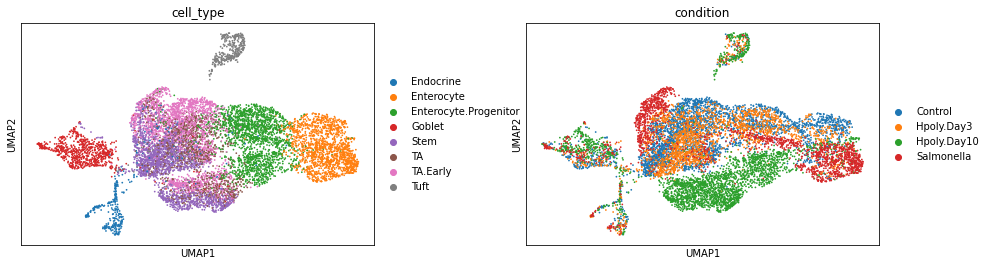

In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'condition'], wspace=0.3)

Our UMAP plots look sensible (e.g. we see good separation between cell types and disease state), so we'll proceed with saving the final version.

In [9]:
df = pd.DataFrame(adata.X[:, adata.var['highly_variable']]) # Extract values for highly variable genes only

df.to_csv('./preprocessed_data.csv')
metadata_df.to_csv('./metadata.csv')